In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [3]:
data = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=tr)

val_data = torch.utils.data.Subset(data, range(12000))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

train_data = torch.utils.data.Subset(data, range(12000, 60000))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST('./MNIST_data', download=True, train=False, transform=tr)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, num_workers=1)

In [4]:
train_data

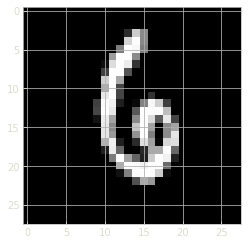

In [5]:
plt.imshow(train_data[2][0].reshape(28, 28), cmap='gray');

In [6]:
train_data[2][0].target

AttributeError: 'Tensor' object has no attribute 'target'

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 5, 3, padding=1),
                                    nn.BatchNorm2d(5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(3))
        self.layer2 = nn.Sequential(nn.Conv2d(5, 5, 3, padding=1),
                                    nn.BatchNorm2d(5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(3))
        self.layer3 = nn.Sequential(nn.Linear(45, 32),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(32, 10))

    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = X.reshape(X.size(0), -1)
        X = self.layer3(X)
        X = self.layer4(X)
        return X

    def evaluate(self, X):
        if len(X.size()) == 3:
            X.unsqueeze(0)
        Y = self.forward(X)
        return torch.argmax(Y, dim=1)

In [26]:
def is_overfitting(net, past_val_acc):
    val_x, val_y = [(x, y) for x, y in val_loader][0]
    predicted_class = net.evaluate(val_x)
    past_val_acc.append((predicted_class == val_y).float().mean().item())

    if len(past_val_acc) >=10  and sum(past_val_acc[-10:-5]) > sum(past_val_acc[-5:]):
        return True
    return False

In [35]:
net = Net()
params = list(net.parameters())
opt = optim.Adam(params)
criterion = nn.CrossEntropyLoss()

In [36]:
epochs = 10
overfit = False
past_val_acc = []
past_models = []

In [37]:
for i in range(epochs):
    for j, (inputs, labels) in enumerate(train_loader):
        opt.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()

        if j % 100 == 0 and is_overfitting(net, past_val_acc):
            overfit = True
            break

        if (j + 1) % 100 == 0:
            past_models.append(deepcopy(net))
            print("Epoche:", i + 1, "Batch:", j + 1, "Loss:", loss.item())

    if overfit:
         break

Epoche: 1 Batch: 100 Loss: 1.455858826637268


Epoche: 1 Batch: 200 Loss: 0.6893303990364075


Epoche: 1 Batch: 300 Loss: 0.49128952622413635


Epoche: 1 Batch: 400 Loss: 0.3726753890514374


Epoche: 1 Batch: 500 Loss: 0.30385279655456543


Epoche: 1 Batch: 600 Loss: 0.27861684560775757


Epoche: 1 Batch: 700 Loss: 0.22920826077461243


Epoche: 2 Batch: 100 Loss: 0.30876535177230835


Epoche: 2 Batch: 200 Loss: 0.26486068964004517


Epoche: 2 Batch: 300 Loss: 0.11253345757722855


Epoche: 2 Batch: 400 Loss: 0.19519777595996857


Epoche: 2 Batch: 500 Loss: 0.21302084624767303


Epoche: 2 Batch: 600 Loss: 0.10333795100450516


Epoche: 2 Batch: 700 Loss: 0.22154662013053894


Epoche: 3 Batch: 100 Loss: 0.13588449358940125


Epoche: 3 Batch: 200 Loss: 0.0853755846619606


Epoche: 3 Batch: 300 Loss: 0.055198609828948975


Epoche: 3 Batch: 400 Loss: 0.2953740954399109


Epoche: 3 Batch: 500 Loss: 0.09079385548830032


Epoche: 3 Batch: 600 Loss: 0.07422075420618057


In [38]:
len(past_models)

20

In [39]:
past_val_acc

[0.125,
 0.703125,
 0.859375,
 0.9375,
 0.96875,
 0.9375,
 0.953125,
 0.921875,
 0.921875,
 0.9375,
 0.984375,
 0.984375,
 0.921875,
 0.96875,
 0.953125,
 0.953125,
 0.96875,
 0.96875,
 0.953125,
 0.96875,
 0.953125,
 0.953125,
 0.96875]

In [44]:
test_x, test_labels = [(data, target) for data, target in test_loader][0]
predicted_class = net.evaluate(test_x)

(predicted_class == test_labels).float().mean().item()

0.9613000154495239